# Vanilla reverse integrability

A good test of the integrator is first integrate our points backward, and then re-integrate them forward. If the integrator works properly, we should return to the current position only limited by numerical precision from the time step size. This notebook shows the different between the positions of the globular clusters when integrated backwards as point masses and then integrated forward. 

*Vanilla* in this experiment means the most basic case: integrating point masses in the time-static and axis-symmetric potential to represent the Milky Way

In [1]:
import tstrippy
from astropy import units as u
from astropy import constants as const
from astropy import coordinates as coord
import numpy as np
import matplotlib.pyplot as plt
import datetime

update rc params for nice looking plots

In [2]:
# give each object a color 
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 15,
})

create a function for standarized plots

In [3]:
def plot_relative_stability(tBack,relativeR,relativaV,colors,rlabel,vlabel,title,timestep,
                            ylims=[1e-20,1e-9]):
    """ Plot the relative stability of the integration of the orbits
    Parameters:
    -----------
    tBack: array
        Array of the integration time in seconds
    relativeR: array
        Array of the relative difference in the position of the objects
    relativeV: array
        Array of the relative difference in the velocity of the objects
    colors: array
        Array of the colors of the objects
    rlabel: string
        Label of the y-axis of the position plot
    vlabel: string
        Label of the y-axis of the velocity plot
    title: string
        Title of the plot
    timestep: float
        Time step of the integration in years
    ylims: array
        Limits of the y-axis of the plots
    
    """
    nGC=len(relativeR)
    fig,axis=plt.subplots(2,1,figsize=(12,8),sharex=True,gridspec_kw={'hspace':0})
    for i in range(nGC):
        axis[0].plot(tBack,relativeR[i],color=colors[i],alpha=0.5)
        axis[1].plot(tBack,relativaV[i],color=colors[i],alpha=0.5)
    for ax in axis:
        ax.set_yscale('log')
        ax.set_xlim(tBack[0],tBack[-1])
        ax.set_ylim(*ylims)
    axis[0].set_ylabel(rlabel,fontsize=25,rotation=0,labelpad=20)
    axis[1].set_ylabel(vlabel,fontsize=25,rotation=0,labelpad=20)
    axis[1].set_xlabel('Integration time [s kpc/ km]')
    y0ticks=axis[0].get_yticks()
    y1ticks=axis[1].get_yticks()
    axis[0].set_yticks(y0ticks[2:-1]);
    axis[1].set_yticks(y1ticks[1:-2]);
    axis[0].set_title(title)
    axis[0].text(0.95,0.95,'Difference between integrating backward and reintegrating forward',transform=axis[0].transAxes,ha='right',va='top')
    axis[0].text(0.95,0.15,"Integration time step: {:.1e}".format(timestep),transform=axis[0].transAxes,ha='right',va='top')
    return fig,axis

create a function that computes the difference in distance and speed between the forward and backward integration

In [4]:
def get_dr_dv_rmean_vmean(backwardOrbit,forwardOrbit):
    """
    Calculate the difference in position and velocity between the backward and forward integration
    """
    dx=backwardOrbit[1]-forwardOrbit[1]
    dy=backwardOrbit[2]-forwardOrbit[2]
    dz=backwardOrbit[3]-forwardOrbit[3]
    dr=np.sqrt(dx**2+dy**2+dz**2)
    dvx=backwardOrbit[4]-forwardOrbit[4]
    dvy=backwardOrbit[5]-forwardOrbit[5]
    dvz=backwardOrbit[6]-forwardOrbit[6]
    dv=np.sqrt(dvx**2+dvy**2+dvz**2)
    xmean=(backwardOrbit[1]+forwardOrbit[1])/2
    ymean=(backwardOrbit[2]+forwardOrbit[2])/2
    zmean=(backwardOrbit[3]+forwardOrbit[3])/2
    vxmean=(backwardOrbit[4]+forwardOrbit[4])/2
    vymean=(backwardOrbit[5]+forwardOrbit[5])/2
    vzmean=(backwardOrbit[6]+forwardOrbit[6])/2
    rmean=np.sqrt(xmean**2+ymean**2+zmean**2)
    vmean=np.sqrt(vxmean**2+vymean**2+vzmean**2)
    return dr,dv,rmean,vmean

def dynamical_time_sorter(x,y,z,vx,vy,vz):
    """
        For making the plots prettier, sort the clusters by a crude estimate of the dynamical time.
    """
    # get an estimate of all dynamical times of the cluster
    r0=np.sqrt(x**2+y**2+z**2)
    v0=np.sqrt(vx**2+vy**2+vz**2)
    Tdyn=r0/v0
    # sort the clusters by dynamical time
    idx=np.argsort(Tdyn)
    return idx

a function to load our integration units

In [5]:
def loadunits():
    # Load the units
    unitbasis = tstrippy.Parsers.potential_parameters.unitbasis
    unitT=u.Unit(unitbasis['time'])
    unitV=u.Unit(unitbasis['velocity'])
    unitD=u.Unit(unitbasis['distance'])
    unitM=u.Unit(unitbasis['mass'])
    unitG=u.Unit(unitbasis['G'])
    G = const.G.to(unitG).value
    return unitT, unitV, unitD, unitM, unitG, G

a function that loads the globular cluster positions and velocities into galactic coordinates

In [6]:
def load_globular_clusters_in_galactic_coordinates(MWrefframe):
    """Extract all initial conditions of the globular clusters and transform them the MW frame"""
    unitT, unitV, unitD, unitM, unitG, G = loadunits()
    GCdata  =   tstrippy.Parsers.baumgardtMWGCs().data
    skycoordinates=coord.SkyCoord(
        ra=GCdata['RA'],
        dec=GCdata['DEC'],
        distance=GCdata['Rsun'],
        pm_ra_cosdec=GCdata['mualpha'],
        pm_dec=GCdata['mu_delta'],
        radial_velocity=GCdata['RV'],)
    galacticcoordinates = skycoordinates.transform_to(MWrefframe)
    x,y,z=galacticcoordinates.cartesian.xyz.to(unitD).value
    vx,vy,vz=galacticcoordinates.velocity.d_xyz.to(unitV).value
    return x,y,z,vx,vy,vz

this function first integrates the clusters backwards in time. It then extacts their final positions and reintegrates them forward in time. The backward and forward orbtis are saved

In [7]:
def vanilla_clusters(integrationtime,timestep,staticgalaxy,initialkinematics):
    """
    do the backward and forward integration of the vanilla clusters
    """
    assert isinstance(integrationtime,u.Quantity)
    assert isinstance(timestep,u.Quantity)
    unitT, unitV, unitD, unitM, unitG, G = loadunits()
    Ntimestep=int(integrationtime.value/timestep.value)
    dt=timestep.to(unitT)
    currenttime=0*unitT
    integrationparameters=[currenttime.value,dt.value,Ntimestep]
    nObj = initialkinematics[0].shape[0]

    tstrippy.integrator.setstaticgalaxy(*staticgalaxy)
    tstrippy.integrator.setinitialkinematics(*initialkinematics)
    tstrippy.integrator.setintegrationparameters(*integrationparameters)
    tstrippy.integrator.setbackwardorbit()
    xBackward,yBackward,zBackward,vxBackward,vyBackward,vzBackward=\
        tstrippy.integrator.leapfrogintime(Ntimestep,nObj)
    tBackward=tstrippy.integrator.timestamps.copy()
    tstrippy.integrator.deallocate()

    #### Now compute the orbit forward
    #### IT'S VERY IMPORTANT TO USE tBackward[-1] AS THE CURRENT TIME FOR THE FORWARD INTEGRATION
    #### BEFORE I USED -integrationtime, WHICH CAN BE DIFFERENT BY NSTEP * 1e-16
    #### I.e. A DRIFT IN TIME DUE TO NUMERICAL ERROR, WHICH CAN BECOME SIGNIFICANT FOR INTEGRATING WITH THE BAR
    currenttime=tBackward[-1]*unitT

    integrationparameters=[currenttime.value,dt.value,Ntimestep]
    x0,y0,z0=xBackward[:,-1],yBackward[:,-1],zBackward[:,-1]
    vx0,vy0,vz0 = -vxBackward[:,-1],-vyBackward[:,-1],-vzBackward[:,-1]
    initialkinematics=[x0,y0,z0,vx0,vy0,vz0]
    tstrippy.integrator.setstaticgalaxy(*staticgalaxy)
    tstrippy.integrator.setintegrationparameters(*integrationparameters)
    tstrippy.integrator.setinitialkinematics(*initialkinematics)
    xForward,yForward,zForward,vxForward,vyForward,vzForward=\
        tstrippy.integrator.leapfrogintime(Ntimestep,nObj)
    tForward=tstrippy.integrator.timestamps.copy()
    tstrippy.integrator.deallocate()

    # flip the backorbits such that the point in the past, 
    # which should be the common starting point, 
    # is the first point for both the forward and backward orbits
    tBackward=tBackward[::-1]
    xBackward,yBackward,zBackward=xBackward[:,::-1],yBackward[:,::-1],zBackward[:,::-1]
    vxBackward,vyBackward,vzBackward=-vxBackward[:,::-1],-vyBackward[:,::-1],-vzBackward[:,::-1]
    backwardOrbit  = [tBackward,xBackward,yBackward,zBackward,vxBackward,vyBackward,vzBackward]
    forwardOrbit   = [tForward,xForward,yForward,zForward,vxForward,vyForward,vzForward]
    return backwardOrbit,forwardOrbit

## Load

Get the Milky Way potential parameters, reference frame, and globular cluster positions and masses

In [8]:
MWparams        = tstrippy.Parsers.potential_parameters.pouliasis2017pii()
MWrefframe      = tstrippy.Parsers.potential_parameters.MWreferenceframe()  
x,y,z,vx,vy,vz  = load_globular_clusters_in_galactic_coordinates(MWrefframe)
staticgalaxy    = ["pouliasis2017pii", MWparams]
initialkinematics=[x,y,z,vx,vy,vz]

get a unique color for each cluster based on the dynamical time

In [9]:
cmap = plt.get_cmap('twilight')
nGC = len(x)
colors = cmap(np.linspace(0, 1, nGC))

Set the total integration time and a series of timesteps to test the integration fidelity 

In [10]:
integrationtime =   5e9 * u.yr
timesteps = [1e7*u.yr,1e6*u.yr,1e5*u.yr,1e4*u.yr,]
timesteps = [5e3*u.yr,1e4*u.yr,1e5*u.yr,1e6*u.yr,1e7*u.yr]

Set plot properties

In [11]:
rlabel = r"$\frac{|\delta\vec{r}|}{\langle r \rangle}$"
vlabel = r"$\frac{|\delta\vec{v}|}{\langle v \rangle}$"
ylims = [1e-20,1e-3]

integrate with a series of different timesteps to show the stability of the cluster orbits

In [12]:
computation_time = []
realtive_Rs = []
relative_Vs = []
ts = []
for timestep in timesteps:
    starttime = datetime.datetime.now()
    backwardOrbit,forwardOrbit=\
        vanilla_clusters(integrationtime,timestep,staticgalaxy,initialkinematics)
    endtime=datetime.datetime.now()
    computation_time.append(endtime-starttime)
    dr,dv,rmean,vmean = get_dr_dv_rmean_vmean(backwardOrbit,forwardOrbit)
    idx = dynamical_time_sorter(x,y,z,vx,vy,vz)
    dr,dv,rmean,vmean = dr[idx],dv[idx],rmean[idx],vmean[idx]
    realtive_Rs.append(dr/rmean)
    relative_Vs.append(dv/vmean)
    ts.append(backwardOrbit[0])


view the stability results

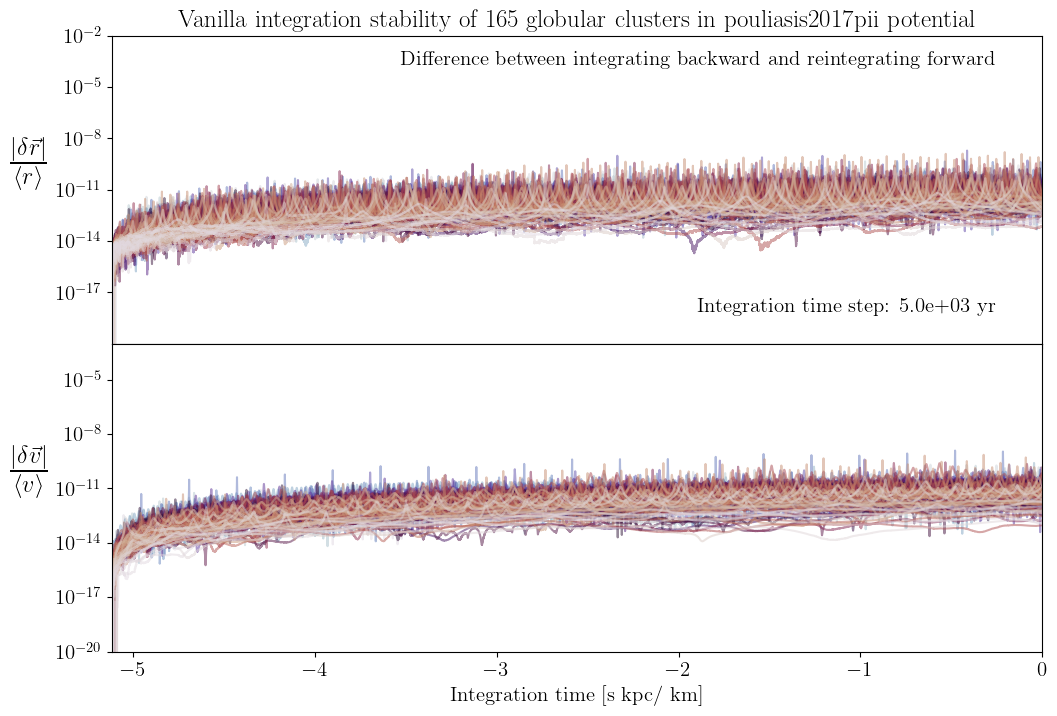

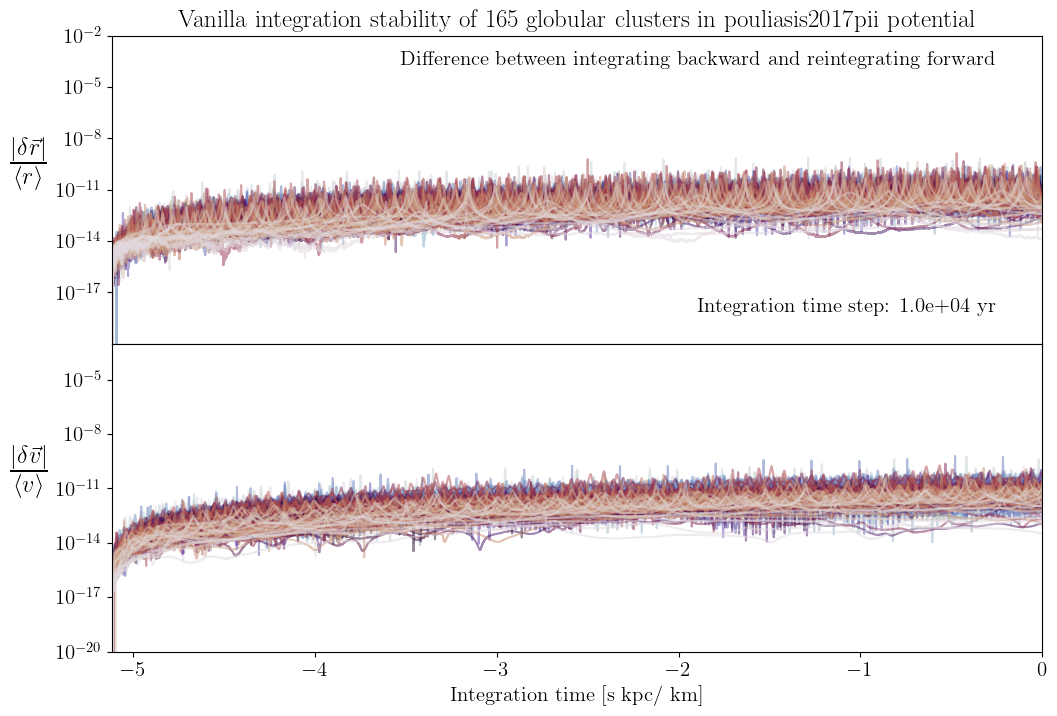

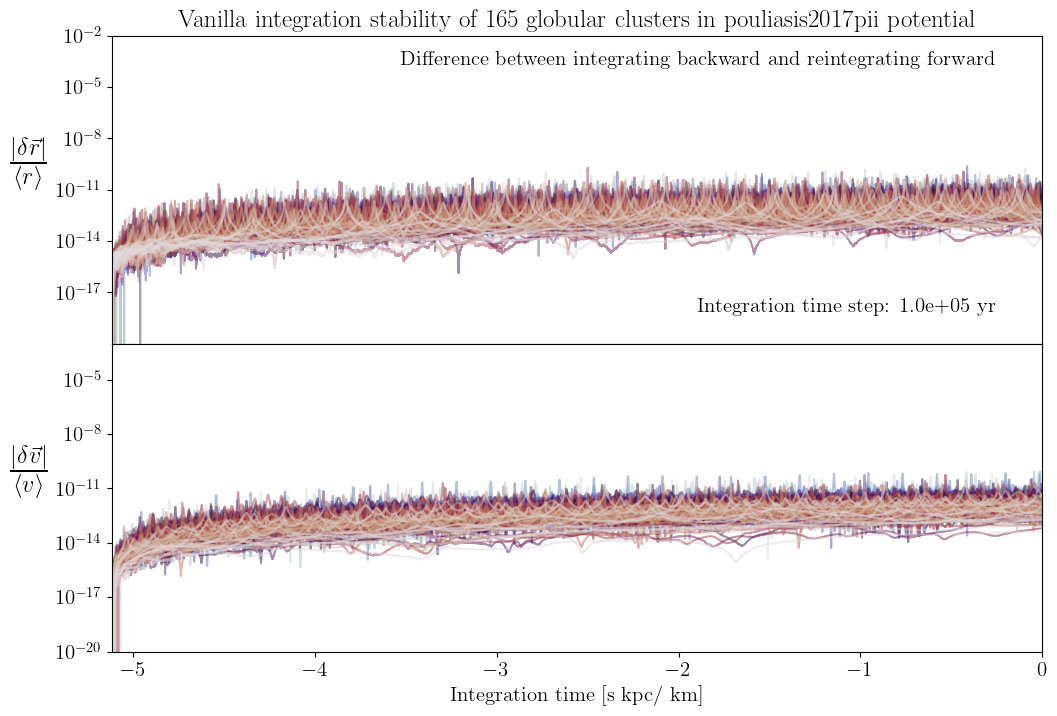

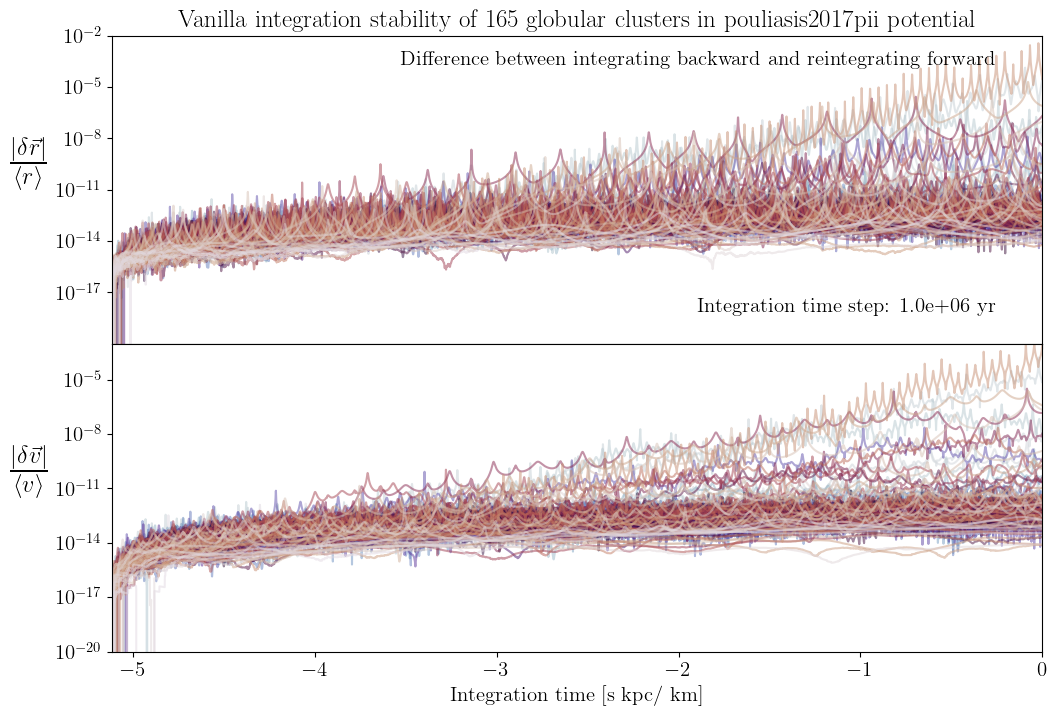

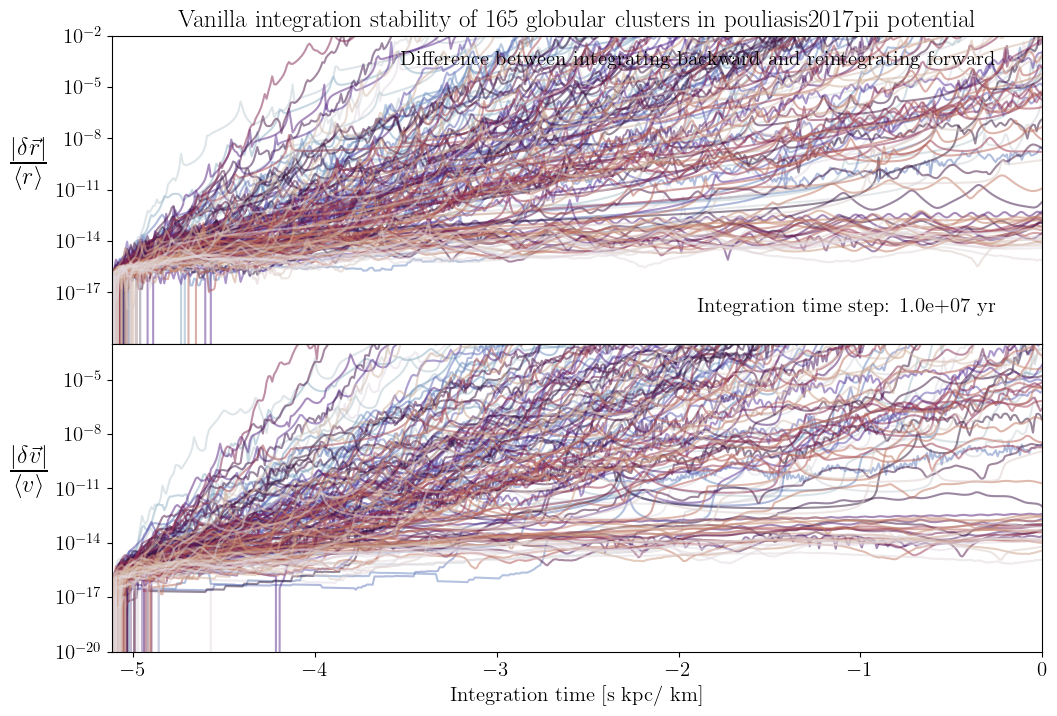

In [13]:
for i in range(len(timesteps)):
    title = r"Vanilla integration stability of {:d} globular clusters in {:s} potential".format(nGC,staticgalaxy[0])
    fig,axis = plot_relative_stability(ts[i],realtive_Rs[i],relative_Vs[i],colors,rlabel,vlabel,title,timesteps[i],ylims)

Check the time dependence on the number of integration steps 

Text(0, 0.5, 'Comp time per step [s]')

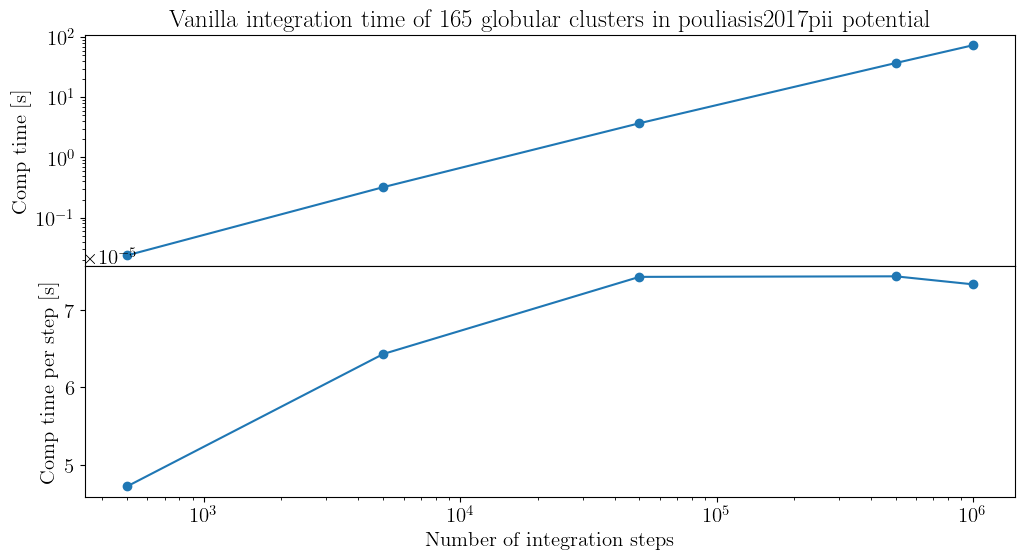

In [14]:
NSTEPS =  [int(integrationtime.to(u.yr).value/timestep.to(u.yr).value) for timestep in timesteps]
time_per_step = [computation_time[i].total_seconds()/NSTEPS[i] for i in range(len(NSTEPS))]
title = r"Vanilla integration time of {:d} globular clusters in {:s} potential".format(nGC,staticgalaxy[0])

fig,axis=plt.subplots(2,1,figsize=(12,6),sharex=True,gridspec_kw={'hspace':0})
axis[0].plot(NSTEPS,[ct.total_seconds() for ct in computation_time],marker='o')
axis[1].plot(NSTEPS,time_per_step,marker='o')
axis[0].set_yscale('log')
axis[1].set_xlabel('Number of integration steps')
axis[0].set_title(title)
for ax in axis:
    ax.set_xscale('log')
axis[0].set_ylabel('Comp time [s]')
axis[1].set_ylabel('Comp time per step [s]')